In [1]:
from argparse import Namespace
from prafa.universe import Universe
from prafa.portfolio import Portfolio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2677740
Academic license 2677740 - for non-commercial use only - registered to je___@ulaval.ca



\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
LOADING PARAMETERS...
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

FILE /home/ubuntu/Index_Tracking/prafa/dist_matrix/dist_matrix.params EXISTS!
num_vars 500
num_k 30
B_scale_factor 0.0333
D_scale_factor 1.0
problem_path /home/ubuntu/Index_Tracking/prafa/dist_matrix/
problem_name dist_matrix
cost_answer -1000000
T_max 0.01
T_min 0.00001
time_limit 300.0
round_limit 100000000
num_replicas_per_controller 32
num_controllers 1
num_cores_per_controller 1
ladder_init_mode 2
ladder_init_mode 2

////////////////////////////////////////////////////////////////////////////////
FINISHED LOADING PARAMETERS...
////////////////////////////////////////////////////////////////////////////////

Building Model...

FILE /home/ubuntu/Index_Tracking/prafa/dist_matrix/dist_matrix.d EXISTS!
Building Engine...

Running Solver...

.....Solver Done...

Solver Results:
>>>>>>>>>>>>>>>>>>>>>>>>>>

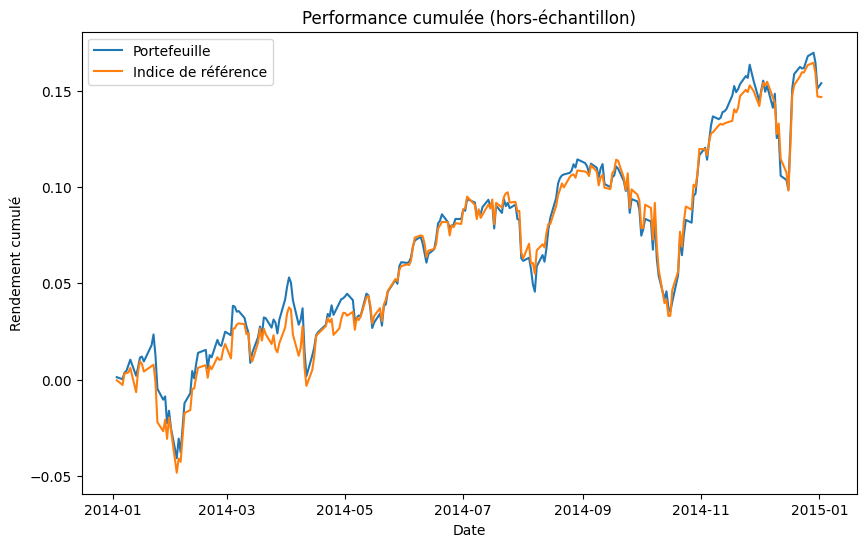

In [2]:
args = Namespace()
args.index = 'sp500'
args.data_path = 'financial_data'
args.result_path = 'results'
args.solution_name = 'quob'
args.rebalancing = 3
args.cardinality = 30
args.start_date = '2014-01-02'
args.end_date = '2025-01-02'

# Initialiser l'objet Universe
universe = Universe(args)
portfolio = Portfolio(universe)
weights = portfolio.rebalance_portfolio(pd.Timestamp("2011-01-02"), pd.Timestamp("2014-01-02"))

test_start  = pd.Timestamp("2014-01-03")
test_end = pd.Timestamp("2015-01-03")

# Extraire rendements entre deux rebalancements
universe.new_universe(test_start, test_end, training=False)
X_test = universe.get_stocks_returns()
Y_test = universe.get_index_returns()


rendements_portefeuille = list(X_test @ weights)
rendements_indice = list(Y_test)
index_dates = list(X_test.index)

# Construire les séries temporelles
rendements_portefeuille = pd.Series(rendements_portefeuille, index=index_dates)
rendements_indice = pd.Series(rendements_indice, index=index_dates)

# Cumuler les rendements
rendements_cumules_portefeuille = (rendements_portefeuille + 1).cumprod() -1
rendements_cumules_indice = (rendements_indice + 1).cumprod() - 1

# Tracer
plt.figure(figsize=(10, 6))  # Taille du graphique

# Tracer les deux courbes
plt.plot(rendements_cumules_portefeuille, label="Portefeuille")
plt.plot(rendements_cumules_indice, label="Indice de référence")

# Ajouter des titres et des labels
plt.title("Performance cumulée (hors-échantillon)")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")

# Afficher la légende et la grille
plt.legend()

# Afficher le graphique
plt.show()

Traitement : QUBO with distance correlation
Traitement : QUBO with simple correletion


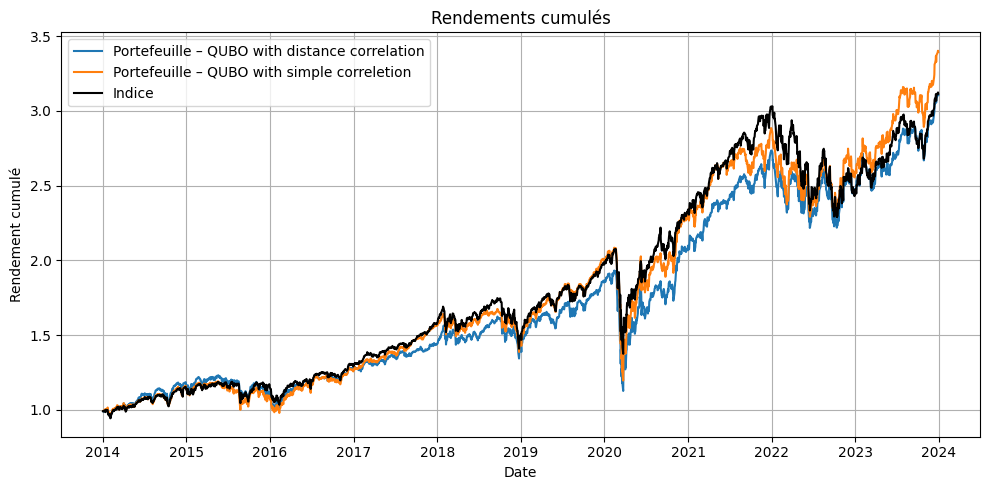

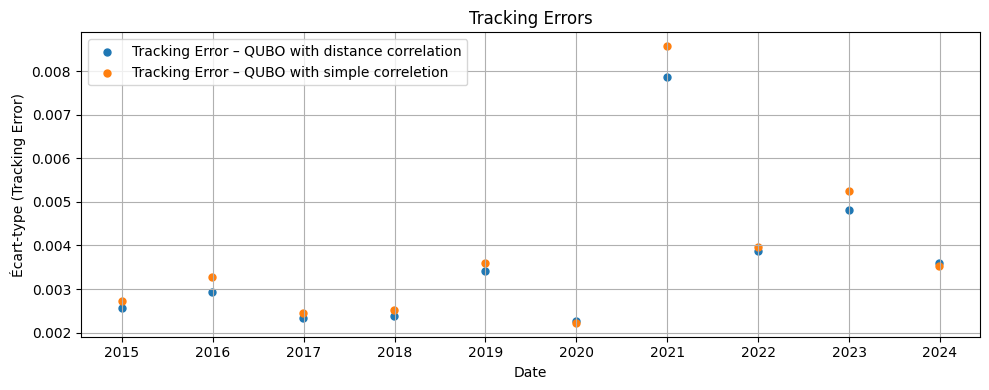

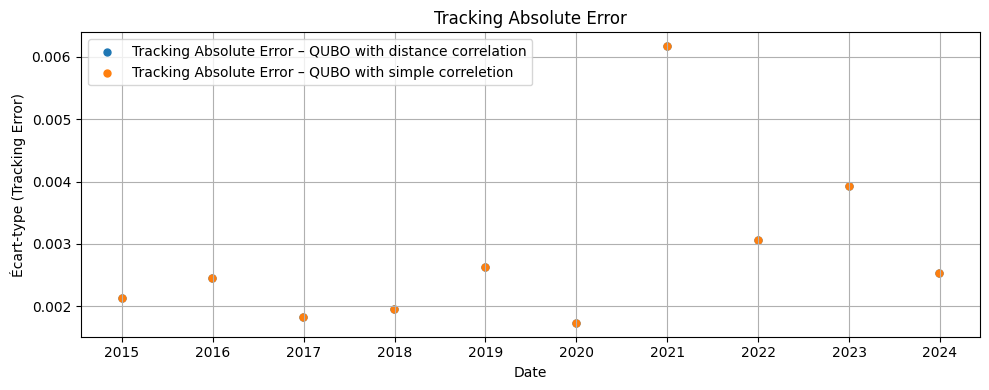

In [2]:


def extract_timeseries(filepath):
    
    with open(filepath, 'rb') as f:
        portfolios = pickle.load(f)
    
    args = Namespace()
    args.index = 'sp500'
    args.data_path = 'financial_data'
    args.result_path = 'results'
    args.solution_name = 'quob'
    args.rebalancing = 12
    args.start_date = '2014-01-02'
    args.end_date = '2025-01-02'

    # Initialiser l'objet Universe
    universe = Universe(args)


    # S'assurer que les dates sont ordonnées
    dates = list(portfolios.keys())
    n = len(dates)

    rendements_portefeuille = []
    rendements_indice = []
    index_dates = []
    tracking_errors = {}
    mae = {}
    for i in range(n - 1):  # On va jusqu'à n-1 car on a besoin de t et t+1
        start_date = dates[i]
        end_date = dates[i + 1] - pd.tseries.offsets.BDay(1)  # veille du prochain rebalance
        # Extraire rendements entre deux rebalancements
        universe.new_universe(start_date, end_date, training=False)
        X_test = universe.get_stocks_returns()
        Y_test = universe.get_index_returns()
        weights = portfolios[start_date]
        
        assert all(X_test.index == Y_test.index), "Les index de X_test et Y_test ne sont pas alignés !"

        return_outsample = X_test @ weights
        tracking_error = (return_outsample - Y_test).std()
        tracking_errors[X_test.index[-1]] = tracking_error
        
        mae[X_test.index[-1]] = (return_outsample - Y_test).abs().mean()

        rendements_portefeuille += list(return_outsample)
        rendements_indice += list(Y_test)
        index_dates += list(X_test.index)

    # Construire les séries temporelles
    rendements_portefeuille = pd.Series(rendements_portefeuille, index=index_dates)
    rendements_indice = pd.Series(rendements_indice, index=index_dates)
    return rendements_portefeuille, rendements_indice, tracking_errors, mae




# ---- Liste des méthodes et chemins associés ----
method_paths = {
             "QUBO with distance correlation":   'results/portfolio_sp500_quob_30.json' ,
             "QUBO with simple correletion" : 'results/portfolio_sp500_quob_cor_30.json'   ,
             }
             #"Gurobi"                       :    
            
    

# ---- Dictionnaires pour stocker les résultats ----
rendements = {}
tracking_errors_all = {}
mae_all = {}
indice_reference = None

# ---- Extraction des données ----
for method, path in method_paths.items():
    print(f"Traitement : {method}")
    rp, ri, te, ae = extract_timeseries(path)
    rendements[method] = rp
    tracking_errors_all[method] = te
    mae_all[method] = ae
    if indice_reference is None:
        indice_reference = ri  # stocker une seule fois l’indice

    
   


# ---- 1. Graphique des rendements cumulés ----
plt.figure(figsize=(10, 5))
for method, rp in rendements.items():
    plt.plot((rp+1).cumprod(), label=f"Portefeuille – {method}")
plt.plot((indice_reference+1).cumprod(), label="Indice", color='black')
plt.title("Rendements cumulés")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 2. Graphique des tracking errors (scatter) ----

plt.figure(figsize=(10, 4))
for method, te in tracking_errors_all.items():
    dates = list(te.keys())
    values = list(te.values())
    plt.scatter(dates, values, label=f"Tracking Error – {method}", s=25)
plt.title("Tracking Errors")
plt.xlabel("Date")
plt.ylabel("Écart-type (Tracking Error)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
for method, te in tracking_errors_all.items():
    dates = list(ae.keys())
    values = list(ae.values())
    plt.scatter(dates, values, label=f"Tracking Absolute Error – {method}", s=25)
plt.title("Tracking Absolute Error")
plt.xlabel("Date")
plt.ylabel("Écart-type (Tracking Error)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

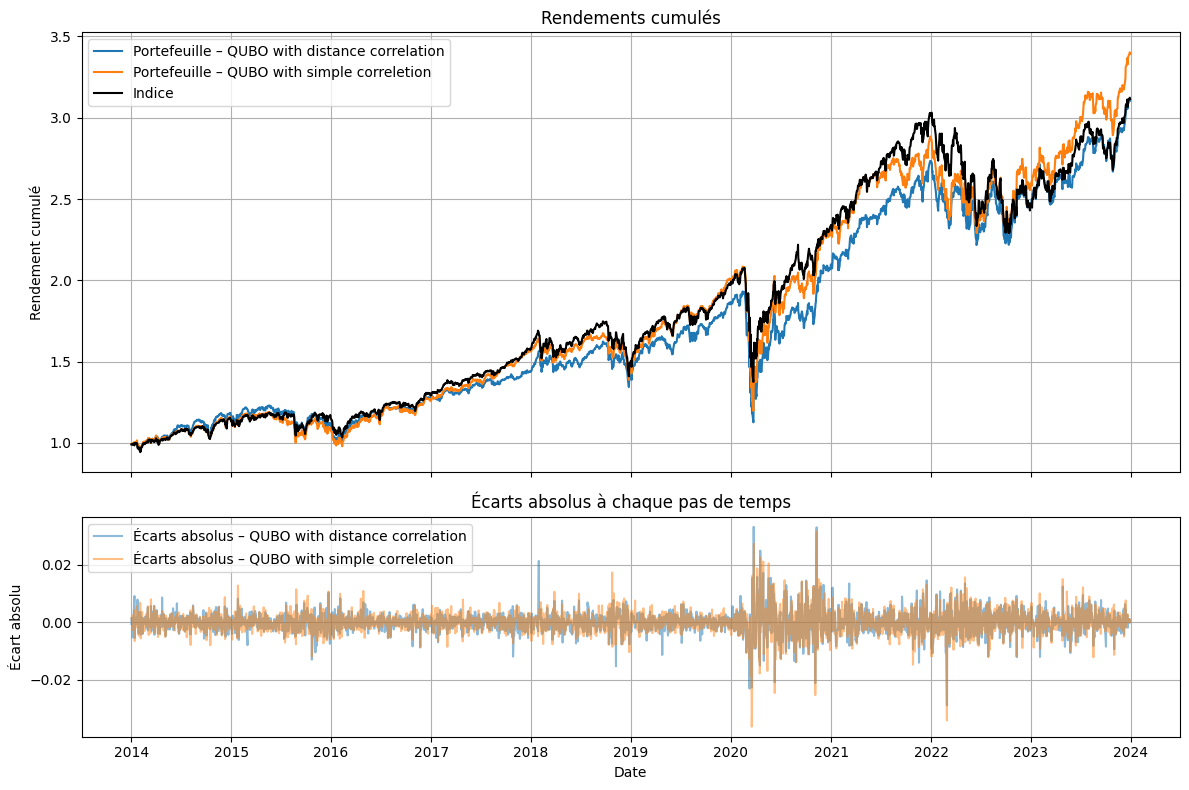

In [3]:
import matplotlib.pyplot as plt

# Créer une figure avec 2 sous-graphes verticaux
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- 1. Rendements cumulés (en haut) ---
for method, rp in rendements.items():
    ax1.plot((rp + 1).cumprod(), label=f"Portefeuille – {method}")
ax1.plot((indice_reference + 1).cumprod(), label="Indice", color='black')
ax1.set_title("Rendements cumulés")
ax1.set_ylabel("Rendement cumulé")
ax1.legend()
ax1.grid(True)

# --- 2. Écarts absolus entre portefeuille et indice (en bas) ---
for method, rp in rendements.items():
    ecarts_absolus = (rp - indice_reference)
    ax2.plot(rp.index, ecarts_absolus, label=f"Écarts absolus – {method}", alpha=0.5)
ax2.set_title("Écarts absolus à chaque pas de temps")
ax2.set_xlabel("Date")
ax2.set_ylabel("Écart absolu")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()




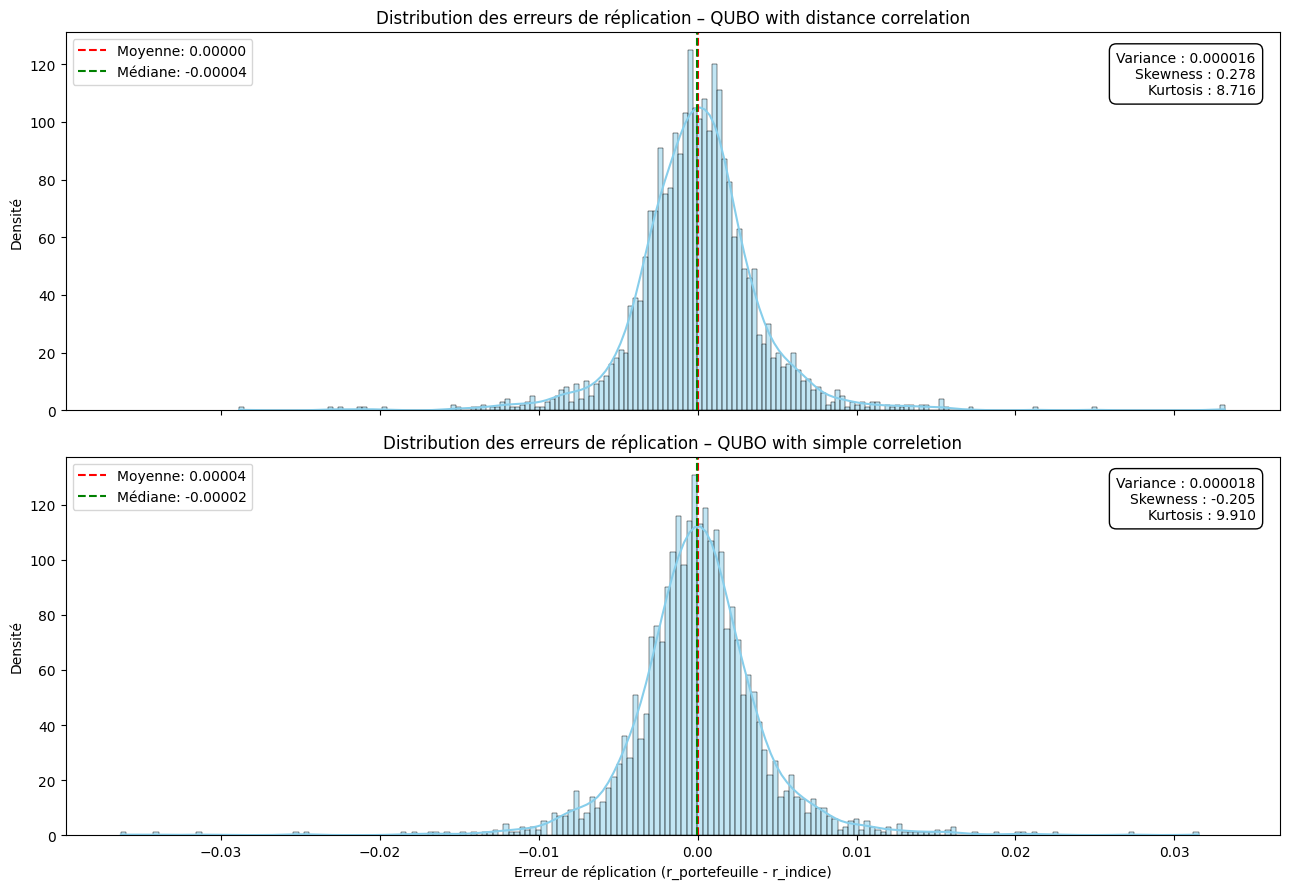

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis

# --- Création du graphe ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 9), sharex=True)

for ax, (method, rp) in zip(axes, rendements.items()):
    erreurs = rp - indice_reference

    # Statistiques
    moyenne = erreurs.mean()
    mediane = erreurs.median()
    variance = erreurs.var()
    skewness = skew(erreurs)
    kurt = kurtosis(erreurs)

    # Tracer l'histogramme
    sns.histplot(erreurs, kde=True, bins=200, ax=ax, color='skyblue', edgecolor='black')
    ax.axvline(moyenne, color='red', linestyle='--', linewidth=1.5, label=f"Moyenne: {moyenne:.5f}")
    ax.axvline(mediane, color='green', linestyle='--', linewidth=1.5, label=f"Médiane: {mediane:.5f}")

    # Titre et légende
    ax.set_title(f"Distribution des erreurs de réplication – {method}", fontsize=12)
    ax.set_ylabel("Densité")
    ax.legend()

    # Texte des stats
    textstr = '\n'.join((
        f'Variance : {variance:.6f}',
        f'Skewness : {skewness:.3f}',
        f'Kurtosis : {kurt:.3f}',
    ))
    ax.text(0.98, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

axes[-1].set_xlabel("Erreur de réplication (r_portefeuille - r_indice)")
plt.tight_layout()
plt.show()
